In [ ]:
#TODO if custom, end with SoftMax

# Imports

In [13]:
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import os

training_dir = '/content/training/'
image_size = (100, 100)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, accuracy_score, f1_score

# Load Files

## Python Version

In [ ]:
import requests, zipfile, io
from pathlib import Path


train1 = "https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip"
train2 = "https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip"
holdout = "https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip"
mini_holdout = "https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip"
mini_holdout_answers = "https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv"

for url in [train1, train2]:
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(training_dir)

for url in [holdout, mini_holdout]:
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall('./content/')

with open('./content/mini_holdout_answers.csv', 'wb') as csv_file:
    csv_file.write(requests.get(mini_holdout_answers).content)

def merge_training (training_dir, folder_name):
    src_path = Path(training_dir).joinpath(folder_name)

    for each_file in src_path.iterdir(): # grabs all files
        trg_path = src_path.parent # gets the parent of the folder
        each_file.rename(trg_path.joinpath(each_file.name)) # moves to parent folder.

    src_path.rmdir()

merge_training(training_dir, 'training1')
merge_training(training_dir, 'training2')

## Colab/ Linux cmd Version

In [4]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


# Split

In [ ]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


# Visualizations and Handy Bits

In [ ]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

print(f'input_size should be {len(target_names)}')

input_size should be 43


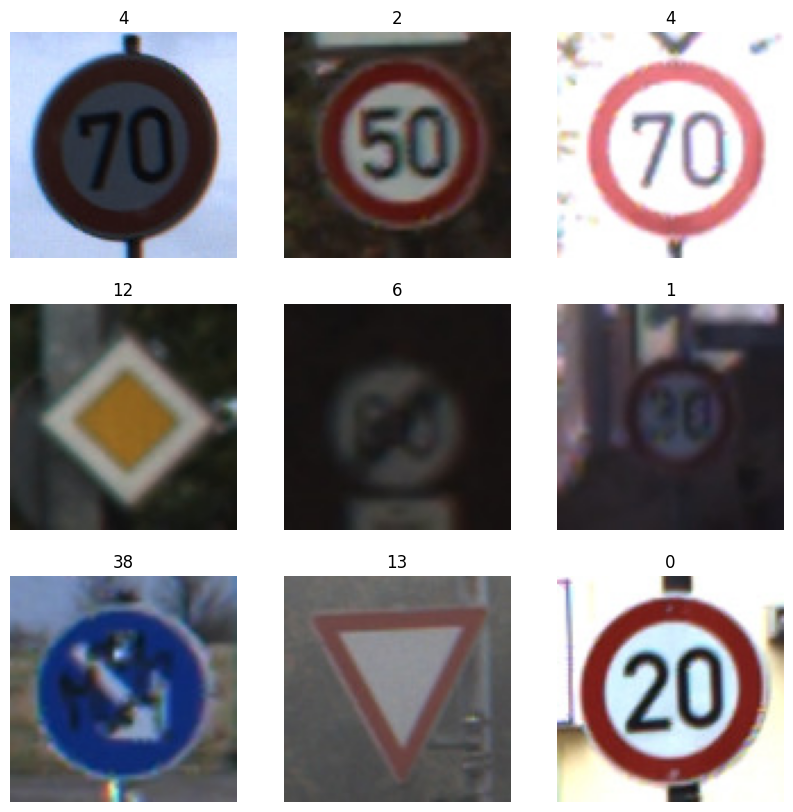

In [ ]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

# Compile and Train

In [ ]:
# Define input shape and number of classes
input_shape = image_size + (3,)
num_classes = 43  # Adjust this to the number of classes in your dataset

# Load base model with pre-trained weights and without top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers on top of base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Converts to shape (None, 2048)
x = Dense(1024, activation='relu')(x)  # Adds a fully connected layer
predictions = Dense(num_classes, activation='softmax')(x)  # Final layer with softmax activation for classification

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights = True)
#'monitor' needs to be val_loss (validation loss)

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping,]
)

Epoch 1/50


e:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


980/980 ━━━━━━━━━━━━━━━━━━━━ 626s 605ms/step - accuracy: 0.7184 - loss: 1.0580 - val_accuracy: 0.9673 - val_loss: 0.1359
Epoch 2/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 9:31 584ms/step - accuracy: 1.0000 - loss: 0.0021

e:\Python\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 4.7684e-07
Epoch 3/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 587s 599ms/step - accuracy: 0.9755 - loss: 0.1011 - val_accuracy: 0.9651 - val_loss: 0.1956
Epoch 4/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 75us/step - accuracy: 0.9688 - loss: 0.0342 - val_accuracy: 1.0000 - val_loss: 1.0252e-05
Epoch 5/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 583s 595ms/step - accuracy: 0.9845 - loss: 0.0670 - val_accuracy: 0.9777 - val_loss: 0.0954
Epoch 6/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 73us/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 1.0000 - val_loss: 6.9141e-06
Epoch 7/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 584s 596ms/step - accuracy: 0.9880 - loss: 0.0619 - val_accuracy: 0.9384 - val_loss: 0.3314
Epoch 8/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 74us/step - accuracy: 1.0000 - loss: 0.0325 - val_accuracy: 1.0000 - val_loss: 7.1525e-06
Epoch 9/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 587s 599ms/step - accuracy: 0.9857 - loss:

In [ ]:
#TODO how to measure performance (some signs more dangerous than others)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path to save the model
model_path = '/content/drive/My Drive/parks_signs_inception.keras'

Mounted at /content/drive


In [14]:
new_model = tensorflow.keras.models.load_model(model_path)

# Show the model architecture
new_model.summary()

NameError: name 'tensorflow' is not defined

In [ ]:
test_dir = './content/mini_holdout'

# Assuming all images are in the same directory and you have a list of file names
file_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)]
labels = [0] * len(file_paths)  # Dummy labels since `class_mode=None` will be used

test_df = pd.DataFrame({
    'filename': file_paths,
    'class': labels
})


In [ ]:


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    class_mode=None,  # No labels are required for prediction
    shuffle=False
)

probabilities = model.predict(test_generator)
mini_predictions = [np.argmax(probas) for probas in probabilities]


Found 201 validated image filenames.


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 423ms/step


In [ ]:
# Create a DataFrame with filenames and predictions
filenames = test_generator.filenames
results = pd.DataFrame({
    'Filename': filenames,
    'ClassId': mini_predictions
})

# Save the results to a CSV file
results.to_csv('parks_signs_mini_predictions.csv', index=False)

print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


In [ ]:
mini_holdout_answers = pd.read_csv('./content/mini_holdout_answers.csv')

mini_holdout_answers.head()

,Filename,ClassId
0,00000.jpg,16
1,00001.jpg,1
2,00002.jpg,38
3,00003.jpg,33
4,00004.jpg,11


In [ ]:
def get_r(predictions, y_test):
  r2 = r2_score(y_test,predictions)
  return r2

def get_mse(predictions, y_test):
  MSE = mean_squared_error(y_test,predictions)
  return MSE

def get_rmse(predictions, y_test):
  rmse = np.sqrt(get_mse(predictions, y_test))
  return rmse

def get_mean_ae(predictions, y_test):
  return mean_absolute_error(y_test,predictions)

def get_median_ae(predictions, y_test):
  return median_absolute_error(y_test,predictions)

def get_accuracy(predictions, y_test):
  return accuracy_score(predictions, y_test)

def get_f1(predictions, y_test):
  f1 = f1_score(y_test,predictions)
  return f1

In [ ]:
def get_scores(predictions, y_test):
  print("R2: ", get_r(predictions, y_test))
  print("MSE: ", get_mse(predictions, y_test))
  print("RMSE: ", get_rmse(predictions, y_test))
  print("Mean Absolute: ", get_mean_ae(predictions, y_test))
  print("Median Absolute: ", get_median_ae(predictions,y_test))
  print("Accuracy: ", get_accuracy(predictions, y_test))


In [ ]:
get_scores(mini_predictions, mini_holdout_answers['ClassId'])

R2:  0.9945262647122228
MSE:  0.7114427860696517
RMSE:  0.8434706788440555
Mean Absolute:  0.15422885572139303
Median Absolute:  0.0
Accuracy:  0.9552238805970149


In [ ]:
model.save('./parks_signs_inception.keras')